In [1]:
import numpy as np
import scipy as sc 
import torch
from torch import nn
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import imageio
from PIL import Image
import cv2


In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context   

#this is for downloding from unverified sources system specific


In [3]:
def relu(x):
    return torch.max(x,torch.tensor(0.))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


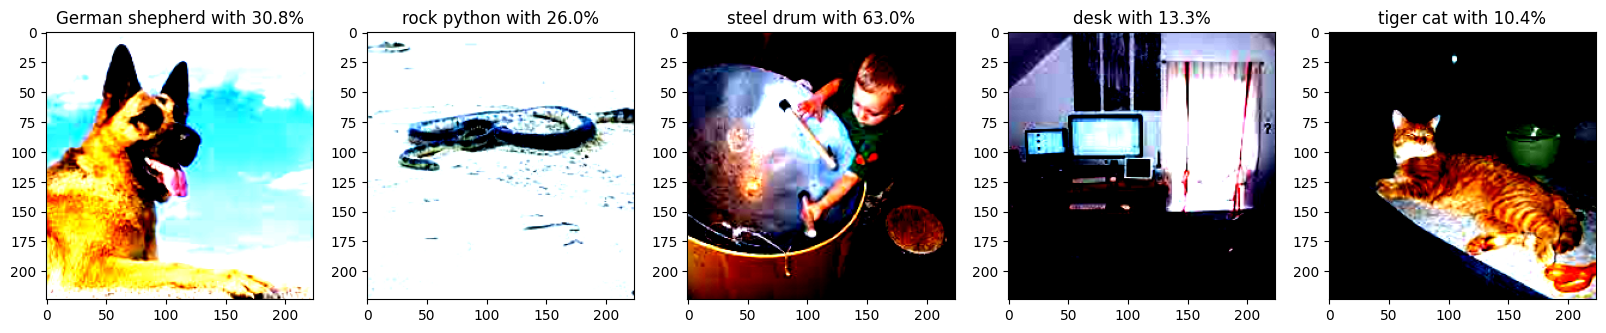

In [4]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()
preprocess = weights.transforms()

image_files = ["./ilsvrc2012-sample-images/i1.jpg", "./ilsvrc2012-sample-images/i2.jpg", "./ilsvrc2012-sample-images/i3.jpg", "./ilsvrc2012-sample-images/i4.jpg", "./ilsvrc2012-sample-images/i5.jpg"]
num_images = len(image_files)

# Create a list to store the preprocessed images
preprocessed_images = []
for i in range(num_images):
    image = read_image(image_files[i])
    preprocessed_image = preprocess(image).unsqueeze(0)
    preprocessed_images.append(preprocessed_image)

print(preprocessed_images[0].shape)

predictions = []
class_ids = []
category_names = []
plt.figure(figsize = (20,10))
for i in range(num_images):
    # Get the predicted category
    prediction = model(preprocessed_images[i]).squeeze(0).softmax(0)
    predictions.append( prediction)
    class_id = prediction.argmax().item()
    class_ids.append(class_id)
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    category_names.append(category_name)
    # Get the original image and display it
    img_show = torch.einsum("chw->hwc", preprocessed_images[i].squeeze()) #convert tensor for displaying Reshape torch.Size([1, 3, 224, 224]) to torch.Size([3, 224, 224])
    plt.subplot(1, num_images, i+1)
    plt.imshow(img_show)
    plt.title(f"{category_name} with {100 * score:.1f}%")

plt.show()

<h3><center>Vanilla Backpropagation</center></h3>

In [5]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<p>Visualizing the gradients helps in understanding the contribution of each pixel in the input image towards the model's prediction. By visualizing the gradients, you can gain insights into which parts of the image have the most significant influence on the model's output.</p>

<p>The process of visualizing the gradients using vanilla backpropagation allows you to identify the regions of the input image that are most important for the model's decision. It helps answer questions like "What features or patterns is the model paying attention to?" or "Which areas of the image have the highest impact on the predicted class?"</p>

<p>By plotting the gradients alongside the corresponding image, you can observe how the gradients highlight certain regions or areas of the image. Higher gradients indicate pixels that strongly influence the model's output, while lower gradients represent pixels with less influence. This visualization can provide valuable insights into the inner workings of the model and help in interpreting its predictions.</p>


<p>Overall, visualizing gradients offers a way to interpret and explain the decision-making process of a deep learning model, providing transparency and insights into its behavior and helping to build trust in the model's predictions.</p>

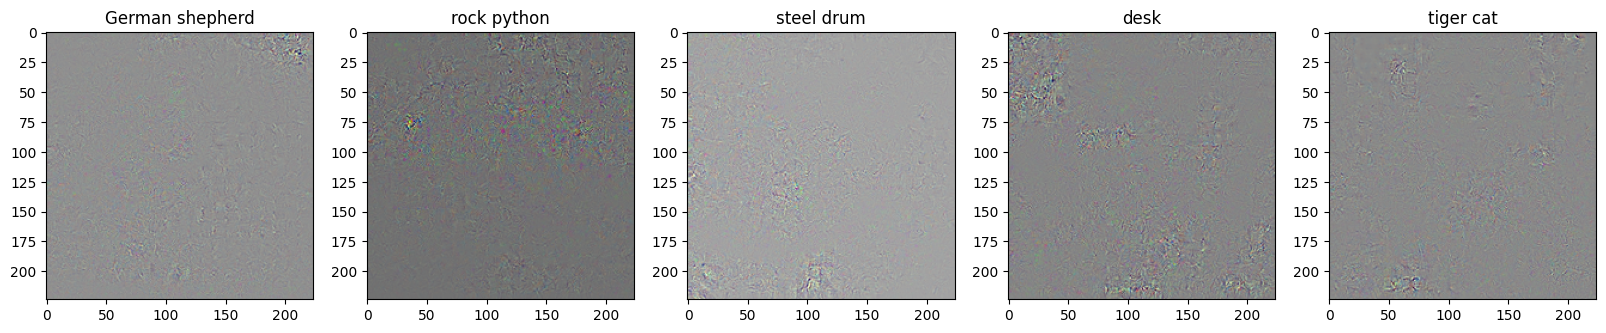

In [6]:
plt.figure(figsize = (20,10))
for i in range(num_images):
    preprocessed_images[i].requires_grad = True
    output = model(preprocessed_images[i]).squeeze(0)
    ts = torch.zeros_like(output).squeeze()
    ts[class_ids[i]] = 1.0
    s_max = torch.dot(ts,output)
    s_max.backward()
    gradients = preprocessed_images[i].grad
    gradients = (gradients - torch.min(gradients))/(torch.max(gradients) - torch.min(gradients)) #normalization
    gradients_show = torch.einsum("chw->hwc",gradients.squeeze())
    plt.subplot(1, num_images, i+1)
    plt.title(f"{category_names[i]}")
    plt.imshow(gradients_show)

<h3><center>Guided-back-propagation</center></h3>

In [7]:
def hook(module,input,output):        #hooks are used to capture or store gradients in non leaf tensors
    temp = torch.zeros_like(input[0])
    temp = input[0]
    hooked_input = relu(temp)
    return (torch.autograd.Variable(hooked_input),)


for name, module in model.named_modules():
    if isinstance(module, nn.ReLU):
        module.register_backward_hook(hook)

<p>Guided Backpropagation visualization is an improvement over the standard or vanilla backpropagation visualization technique. While vanilla backpropagation provides insights into the regions of an input image that are important for the model's prediction, it can also highlight irrelevant or noisy regions. Guided Backpropagation addresses this limitation by emphasizing the relevant features while suppressing the irrelevant ones in the visualization.Here's why Guided Backpropagation visualization is considered better:</p>

* Relevance focus: Guided Backpropagation selectively highlights the relevant regions that contribute positively to the model's prediction. It achieves this by modifying the backpropagation process to only allow positive gradients to flow backward, effectively suppressing negative gradients that might arise from irrelevant or noisy regions. This helps in producing cleaner and more focused visualizations.
* Suppression of irrelevant features: The suppression of negative gradients in Guided Backpropagation helps in reducing the influence of irrelevant or noisy regions in the visualization. By disregarding areas that do not significantly contribute to the prediction, Guided Backpropagation provides more accurate and meaningful visualizations.
* Enhanced interpretability: Guided Backpropagation generates visualizations that are more aligned with human intuition. The emphasized regions tend to align with the actual discriminative features that humans would associate with the predicted class. This improves the interpretability of the model's decision-making process and makes it easier to understand why the model made a particular prediction.
* Reduced visual noise: The suppression of negative gradients in Guided Backpropagation reduces the visual noise in the generated visualizations. This makes it easier to focus on the most important features without being distracted by irrelevant details or artifacts that may be present in vanilla backpropagation visualizations.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


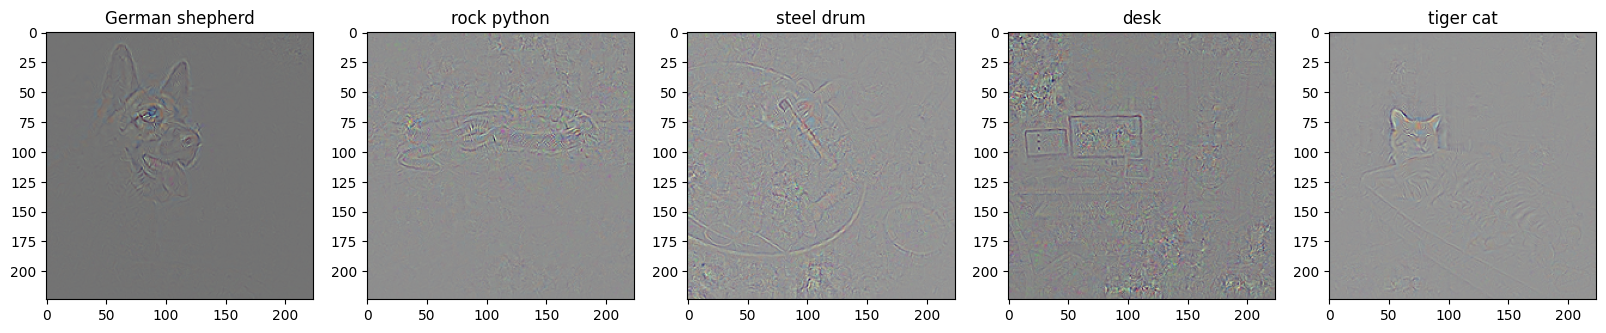

In [ ]:
plt.figure(figsize = (20,10))
guided_back_prop_imgs = []
for i in range(num_images):
    preprocessed_images[i].requires_grad = True
    ot = model(preprocessed_images[i]).squeeze(0)
    ts = torch.zeros_like(ot).squeeze()
    ts[class_ids[i]] = 1.0
    s_max = torch.dot(ts,ot)
    s_max.backward()
    gradients = preprocessed_images[i].grad
    guided_back_prop_imgs.append(gradients)
    gradients = (gradients - torch.min(gradients))/(torch.max(gradients) - torch.min(gradients))
    #normalization
    gradients_show = torch.einsum("chw->hwc",gradients.squeeze())
    plt.subplot(1, num_images, i+1)
    plt.title(f"{category_names[i]}")
    plt.imshow(gradients_show)

<h3><center>Class Activation Map</center></h3>

In [ ]:
sliced_model = nn.Sequential(*list(model.children())[:len(list(model.children()))-2])
print(sliced_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


<p>Class Activation Maps (CAM) are another technique used for visualization in deep learning models, particularly in the context of convolutional neural networks (CNNs) for image classification. CAM provides a spatial localization of the important regions within an image that contribute to the prediction of a particular class.CAM provides a spatial localization of the important regions within an image that contribute to the prediction of a particular class.</p>

<p>CAM has several advantages</p>

* Localization: CAM provides a heatmap-like visualization that directly highlights the most discriminative regions within an image for a specific class. This localization is achieved by leveraging the spatial information captured by the convolutional layers of the CNN. CAM can help identify the exact regions that the model is focusing on, providing fine-grained insights into the decision-making process.

* Efficiency: CAM is computationally efficient compared to Guided Backpropagation. CAM only requires the forward pass through the network and does not involve the backpropagation of gradients. This makes it faster to generate CAM visualizations compared to techniques like Guided Backpropagation, which involve the additional computation of gradients.

* Interpretability: CAM provides intuitive and interpretable visualizations by directly highlighting the regions that contribute to the prediction of a specific class. The visualizations can help in understanding which regions or objects in an image are most relevant for the model's decision. This interpretability is valuable for model understanding, validation, and debugging.

<p>However, it's worth noting that CAM has limitations as well. It primarily focuses on global image-level discrimination and <b>may not capture fine-grained details</b> or localized features.It always need gap layer. Additionally, CAM may not perform well when dealing with complex scenes or images with multiple objects of interest.</p>

<p>In summary, CAM is a powerful and efficient technique for visualizing the important regions within an image that contribute to a specific class prediction. It provides spatial localization and interpretability, making it a valuable tool for understanding and interpreting CNN models. While CAM and Guided Backpropagation serve different purposes, CAM's ability to provide localized visualizations makes it particularly useful for tasks such as object localization and saliency mapping.</p>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


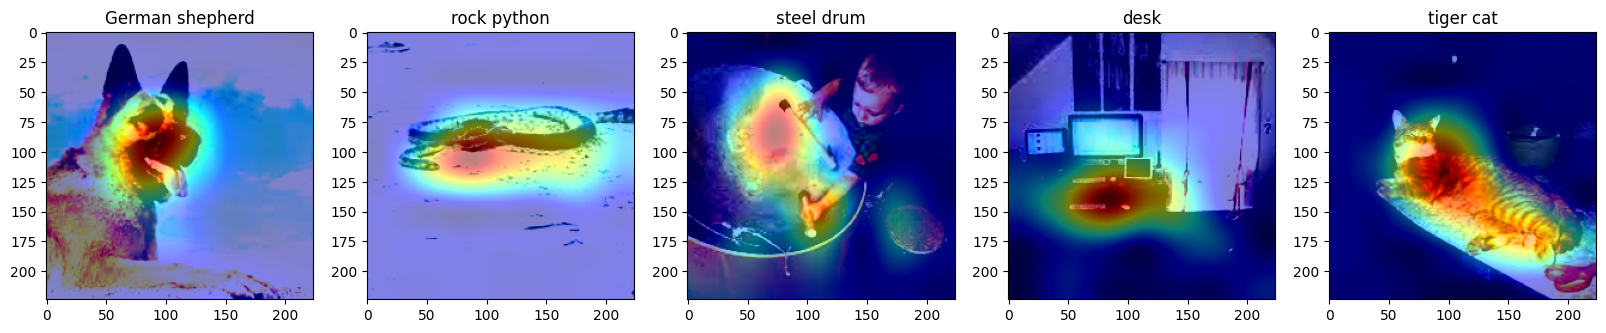

In [10]:
weight_tensor = model.fc.weight # containes all weights
plt.figure(figsize = (20,10))
for i in  range(5):
    sliced_model.eval()
    output = sliced_model(preprocessed_images[i])
    weights = weight_tensor[class_ids[i]][:]
    sum = torch.zeros(7,7)
    for j in range(2048):
        product = output[0][j][:][:]*weights[j]
        sum = sum + product
    sum = sum.detach().numpy() 
    current_image = torch.einsum("chw->hwc", preprocessed_images[i].squeeze()).detach().numpy()
    resized_sum = cv2.resize(sum, (224, 224), interpolation=cv2.INTER_CUBIC)
    plt.subplot(1, num_images, i+1)
    plt.title(f"{category_names[i]}")
    plt.imshow(current_image)
    plt.imshow(resized_sum,cmap = 'jet',alpha = 0.5)

<h3><center>Guided Grad-CAM</center></h3>

In [11]:
global glb
glb = []
def hook_guided(module,input,output):
    glb.append(input[0])
    return 

for name, module in model.named_modules():
    if (name == 'layer4.2.relu'):
        if isinstance(module, nn.ReLU):
            module.register_backward_hook(hook_guided)


<p>Guided Grad-CAM (Gradient-weighted Class Activation Mapping) combines the strengths of both Guided Backpropagation and Class Activation Maps (CAM) to provide a more informative and accurate visualization of the important regions within an image for a specific class. Here's why Guided Grad-CAM is preferred over CAM:</p>

* Localization and spatial precision: Guided Grad-CAM retains the localization capability of CAM by providing a heatmap-like visualization that highlights the discriminative regions within an image. It accurately identifies the regions that contribute to the prediction of a particular class, allowing for precise spatial localization.

* Incorporation of gradients: Guided Grad-CAM leverages the gradients flowing through the network during backpropagation to weight the CAM visualization. By multiplying the CAM with the gradients, Guided Grad-CAM assigns higher importance to regions where the gradients are large. This incorporation of gradients helps to further refine the visualizations, providing more accurate and informative results.

* Fine-grained details: Guided Grad-CAM captures both the local details and the global discriminative regions within an image. It can highlight fine-grained features and localized areas of importance, providing a more comprehensive understanding of the model's decision-making process.

* Interpretability: Guided Grad-CAM generates visualizations that are not only accurate but also highly interpretable. The visualizations clearly indicate the important regions and provide insights into why the model makes certain predictions. This interpretability is crucial for understanding and validating the model's behavior.

<p>Overall, Guided Grad-CAM offers the advantages of both localization and the integration of gradients, resulting in more precise, informative, and interpretable visualizations. It is a powerful tool for visualizing the decision-making process of deep learning models and gaining insights into the features that contribute to their predictions.</p>

torch.Size([2048, 7, 7])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([2048, 7, 7])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([2048, 7, 7])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([2048, 7, 7])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([2048, 7, 7])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])


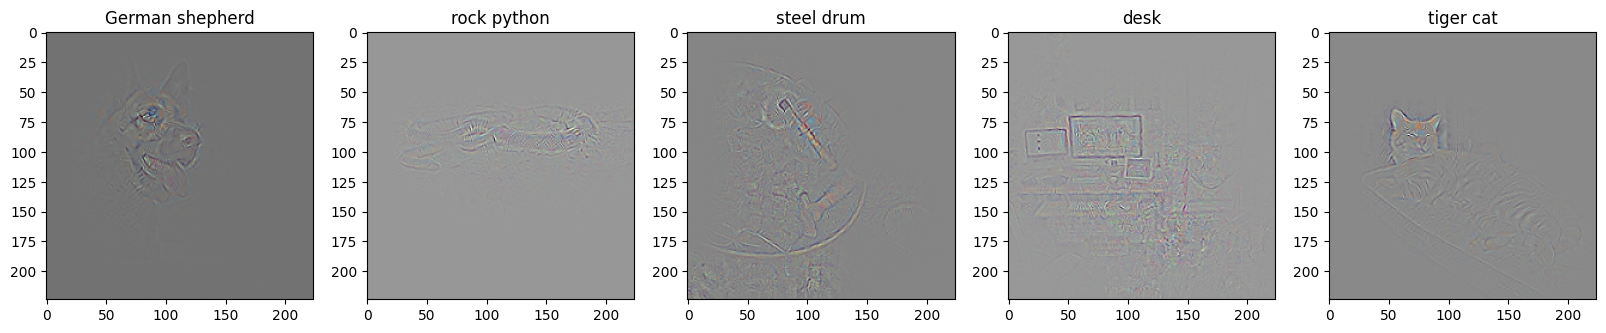

In [12]:
plt.figure(figsize = (20,10))
for i in range(num_images):
    preprocessed_images[i].requires_grad = True
    ot = model(preprocessed_images[i]).squeeze()
    ts = torch.zeros_like(ot).squeeze()
    ts[class_ids[i]] = 1.0
    
    s_max = torch.dot(ts,ot)
    s_max.backward() # gradients wrt sclar is need for backprop and we are taking wrt the class
    
    gradients = glb[0].squeeze() # acuumilate gradients  just before gap-layer
    glb = []
    print(gradients.shape)
    gap_grad = torch.zeros(2048,1) #
    for j in range(2048):
        sum = torch.sum(gradients[j][:][:])
        gap_grad[j][0] = sum/49 # as we are taking global average pooling layer for sum
    fnl = torch.zeros(7,7)
    for j in range(2048):
        fnl = fnl + gap_grad[j][0]*gradients[j][:][:]
    
    fnl = relu(fnl) # relu for grad cam
    fnl = cv2.resize(fnl.detach().numpy(),(224, 224))
    resized_fnl = torch.tensor(fnl)
    resized_img = resized_fnl.unsqueeze(-1).repeat(1, 1, 3) # repeating for 3 layers
    #normalization
    resized_img = (resized_img - torch.min(resized_img))/(torch.max(resized_img) - torch.min(resized_img))
    print(resized_img.shape)
    #obtained from guided back-prop
    gd_img = guided_back_prop_imgs[i].squeeze().permute(1,2,0)
    print(gd_img.shape)
    #set the correct order for harmond product
    fnl_img = torch.mul(resized_img,gd_img) #element wise harmond product
   
    #    normalization before ploting without that diffcult for observing as -6.5813e-09, -8.3489e-09 
    #   both are pitch black but there is 10x variation
    fnl_img = (fnl_img - torch.min(fnl_img))/(torch.max(fnl_img) - torch.min(fnl_img))
    
    plt.subplot(1, num_images, i+1)
    plt.title(f"{category_names[i]}")
    plt.imshow(fnl_img)
    